<a href="https://colab.research.google.com/github/dhcryan/kaggle_challenge_/blob/main/week5/donghun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Store Sales - Time Series Forecasting**

 * For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction.

 * you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq '/content/drive/MyDrive/store-sales-time-series-forecasting.zip'

In [4]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from xgboost import XGBClassifier
from xgboost import  XGBRegressor

cuda


In [5]:
import warnings
warnings.filterwarnings("ignore")
from datetime import date,datetime
import time
import calendar

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import seaborn as sns
import calendar
import datetime

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge

In [8]:
path='/content/'

## Read data

index_col=0 을 통해 column 0을 인덱스로

### df_data

**holidays data**

- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016

In [9]:
df_holidays = pd.read_csv(path+'holidays_events.csv',
                          # dtype={
                          #     'type':'category',
                          #     'locale':'category',
                          #     'locale_name':'category',
                          #     'description': 'category',
                          #     'transferred': 'bool',
                          # },
                          parse_dates=['date'],
                          infer_datetime_format=True,
                          )
df_holidays["date"] = df_holidays["date"].dt.to_period('D')
# df_holidays=df_holidays.set_index('date').sort_index()
df_holidays.head()
# df_holidays=df_holidays.set_index('date').to_period('D')

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
df_holidays.type

0         Holiday
1         Holiday
2         Holiday
3         Holiday
4         Holiday
          ...    
345    Additional
346    Additional
347    Additional
348       Holiday
349    Additional
Name: type, Length: 350, dtype: object

In [11]:
work_day=df_holidays.query('type=="Work Day"')['date'].to_frame()
event=df_holidays.query('type=="Event"')['date'].to_frame()

In [12]:
df_holidays=df_holidays.query("(type == 'Holiday' and transferred==False)\
                              or type=='Transfer'\
                              or type=='Bridge'\
                              or type=='Additional'")\
                              .drop(['type','transferred'],axis=1)

In [13]:
df_holidays[df_holidays['date'].dt.year==2016].head(20)
#2016.4.16애 지진이 났다고 하네요

,date,locale,locale_name,description
211,2016-01-01,National,Ecuador,Primer dia del ano
212,2016-02-08,National,Ecuador,Carnaval
213,2016-02-09,National,Ecuador,Carnaval
214,2016-03-02,Local,Manta,Fundacion de Manta
215,2016-03-25,National,Ecuador,Viernes Santo
216,2016-04-01,Regional,Cotopaxi,Provincializacion de Cotopaxi
217,2016-04-12,Local,Cuenca,Fundacion de Cuenca
218,2016-04-14,Local,Libertad,Cantonizacion de Libertad
224,2016-04-21,Local,Riobamba,Cantonizacion de Riobamba
235,2016-05-01,National,Ecuador,Dia del Trabajo


bridge are extra days that are added to a holiday

workday : bridage day 보충

In [14]:
#bridge : 휴일 옆에 붙는 거 
# df_holidays[df_holidays['type']=='Bridge']

In [15]:
# Work day : bridge 랑은 좀 다른 건가봄
# df_holidays[df_holidays['type']=='Work Day']

In [16]:
# df_holidays['transferred'].value_counts()

In [17]:
df_holidays['description']=1
df_holidays

,date,locale,locale_name,description
0,2012-03-02,Local,Manta,1
1,2012-04-01,Regional,Cotopaxi,1
2,2012-04-12,Local,Cuenca,1
3,2012-04-14,Local,Libertad,1
4,2012-04-21,Local,Riobamba,1
...,...,...,...,...
345,2017-12-22,National,Ecuador,1
346,2017-12-23,National,Ecuador,1
347,2017-12-24,National,Ecuador,1
348,2017-12-25,National,Ecuador,1


In [18]:
# real_holiday=df_holidays[(df_holidays['type']!='Work Day') & (df_holidays['transferred']==False)]
# event=real_holiday[real_holiday['type']=='Event']
# earthquake_2016=event[event['description'].str.startswith('Terremoto Manabi')]
# event=event[['date','description']]
# earthquake_2016=earthquake_2016[['date','description']]

**진짜 휴식일(event), 지진날 df**

쉬는 날 유형별 탐색

In [19]:
holiday_local=df_holidays[df_holidays['locale']=='Local'].drop(['locale'],axis=1)
holiday_local.rename(columns={'locale_name':'city','description':'local_holiday'},inplace=True,errors='raise')

holiday_regional=df_holidays[df_holidays['locale']=='Regional'].drop(['locale'],axis=1)
holiday_regional.rename(columns={'locale_name':'state','description':'regional_holiday'},inplace=True,errors='raise')

holiday_national=df_holidays[df_holidays['locale']=='National'].drop(['locale','locale_name'],axis=1)
holiday_national.rename(columns={'description':'national_holiday'},inplace=True,errors='raise')


In [20]:
# holiday_local=real_holiday[real_holiday['locale']=='Local']
# holiday_local=holiday_local[['date','locale_name', 'description']]
# holiday_local.rename(columns={'locale_name':'city','description':'local_holiday'},inplace=True,errors='raise')

# holiday_regional=real_holiday[real_holiday['locale']=='Regional']
# holiday_regional=holiday_regional[['date','locale_name', 'description']]
# holiday_regional.rename(columns={'locale_name':'state','description':'state_holiday'},inplace=True,errors='raise')

# holiday_National=real_holiday[real_holiday['locale']=='National']
# holiday_National=holiday_National[['date','locale_name', 'description']]
# holiday_National.rename(columns={'description':'national_holiday'},inplace=True,errors='raise')
# # holiday_local['city']=holiday_local.rename({'locale_name':'city'},axis=1)

In [21]:
holiday_local

,date,city,local_holiday
0,2012-03-02,Manta,1
2,2012-04-12,Cuenca,1
3,2012-04-14,Libertad,1
4,2012-04-21,Riobamba,1
5,2012-05-12,Puyo,1
...,...,...,...
338,2017-11-12,Ambato,1
339,2017-12-05,Quito,1
341,2017-12-08,Loja,1
342,2017-12-08,Quito,1


뭔가 **train 데이터**에서 가게별로, 가족별로, 날짜별로 판매량, 행사상품따위를 보고 싶다는 생각이 듦

In [22]:
train=pd.read_csv(path+'train.csv',
                  dtype={
                      # # 'store_nbr':'category',
                      # 'family':'category',
                      # 'sales':'float32',
                      # "onpromotion":"uint32"
                  },
                  parse_dates=['date'],
                  infer_datetime_format=True,
                  index_col=0)
train['date']=train.date.dt.to_period('D')
# train=train.set_index(['date', 'store_nbr', 'family']).sort_index()
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


**test 데이터**도 마찬가지로 만들어줌

In [23]:
test=pd.read_csv(path+'test.csv',
                 dtype={
                    # #  'store_nbr':'category',
                    #   'family':'category',
                    #   'onpromotion':'category',
                 },
                 parse_dates=['date'],
                  infer_datetime_format=True,)
test['date'] = test.date.dt.to_period('D')
# test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


**oil data**

결측치가 있으므로 월 평균값으로 대체하였다.

In [24]:
# df_oil에 nan값이 있는 데 이를 주의 평균 값으로 대체 해보자
df_oil=pd.read_csv(path+'oil.csv',
                 dtype={
                     'dcoilwtico':'float64',
                 },
                #  parse_dates=['date'],
                  infer_datetime_format=True,)

df_oil.rename(columns={'dcoilwtico':'oilprice'},inplace=True)
df_oil['month']=df_oil['date'].map(lambda x : int(x.replace('-','')[:6]))
df_oil['m_avg']=df_oil.groupby('month')['oilprice'].transform('mean')
df_oil['tmp']=df_oil['oilprice'].map(np.isnan)
#결측치인것만 평균값으로 대체하는 거임
df_oil['m_avg'] = df_oil['tmp'] * df_oil['m_avg']
df_oil['oilprice'].fillna(0, inplace=True)
df_oil['oilprice'] = df_oil['oilprice'] + df_oil['m_avg']
df_oil=df_oil.drop(['month','m_avg','tmp'],axis=1)
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_oil['date'] = df_oil.date.dt.to_period('D')
df_oil.head()

,date,oilprice
0,2013-01-01,94.756667
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-07,93.200000


In [25]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype    
---  ------    --------------  -----    
 0   date      1218 non-null   period[D]
 1   oilprice  1218 non-null   float64  
dtypes: float64(1), period[D](1)
memory usage: 19.2 KB


Text(0, 0.5, 'Oil_price')

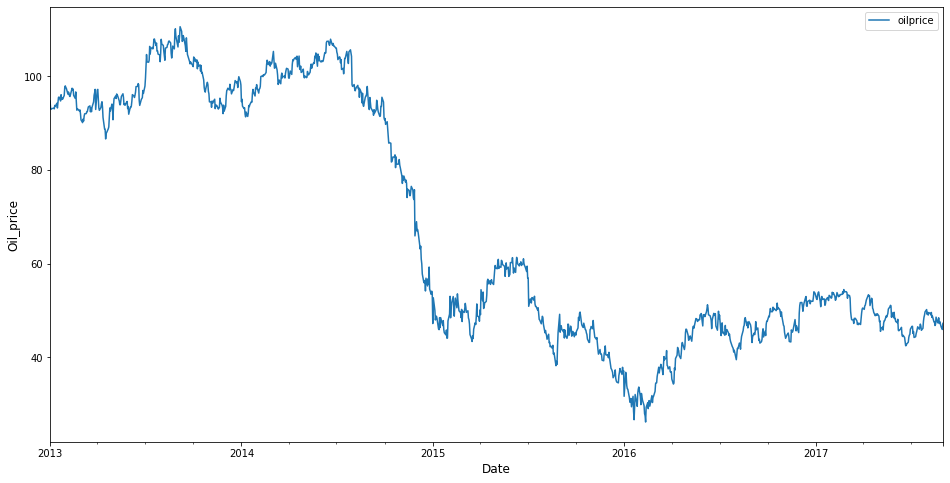

In [26]:
ax=df_oil.set_index('date').plot(figsize=(16,8))
ax.set_xlabel('Date',fontsize='large')
ax.set_ylabel('Oil_price',fontsize='large')

**stores data**

In [27]:
df_stores=pd.read_csv(path+'stores.csv',
                 dtype={
                    # #  "store_nbr":"category",
                    #   "city":"category",
                    #   "state":"category",
                    #   "type":"category",
                    #   "cluster":"category",
                 },
                 )
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [28]:
df_stores.type.value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

**transactions**

Transactions means how many people came to the store or how many invoices created in a day.

Sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

In [29]:
df_trans = pd.read_csv(path+'transactions.csv',
            dtype={
                "transaction":"uint32",
            },
            parse_dates = ["date"],
            infer_datetime_format=True,
           )
df_trans["date"] = df_trans["date"].dt.to_period('D')
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


df_stores 말고는 date 데이터가 있는데 object로 되어 있으니 시계열로 표현하기 위해서 datetime으로 변경

Let's find the relationship between crude oil and grocery sales and transactions.

Weekly average sales

<Figure size 432x288 with 0 Axes>

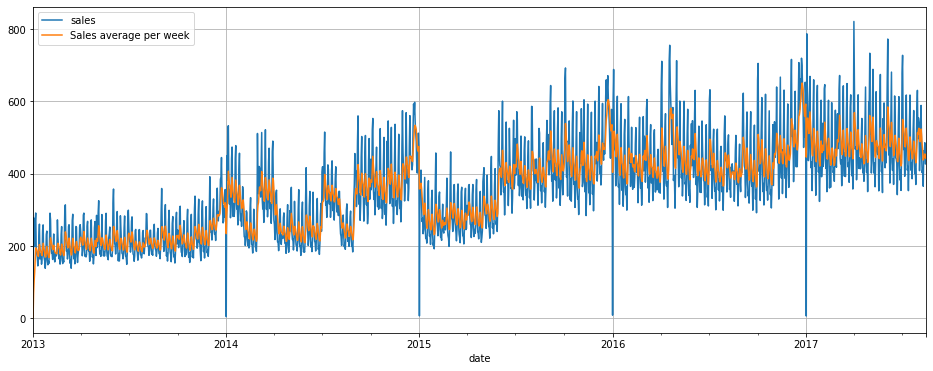

In [30]:
fig=plt.figure()
sales_mean=train.groupby('date').agg({'sales':'mean'}).reset_index()
sales_mean['Sales average per week']=sales_mean['sales'].ewm(span=7,adjust=False).mean()
ax1=sales_mean.plot(x='date',y=['sales','Sales average per week'],figsize=(16,6))
ax1.grid(True)
plt.show()

### null data 파악 및 merge



*   `store_nbr` : the store at which the products are sold.
*   `family` : the type of product sold.
*   `sales` : total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
*   `onpromotion` : total number of items in a product family that were being promoted at a store at a given date.



**Train data merge**

In [31]:
train_=train.merge(df_stores,how='left',on='store_nbr')
train_=train_.merge(df_oil,how='left',on='date')
train_['oilprice']=train_['oilprice'].fillna(method='bfill')
#도시 이름 기준으로 합병
train_=train_.merge(holiday_local,how='left',on=['date','city'])
#주 이름도 추가해주고
train_=train_.merge(holiday_regional,how='left',on=['date','state'])
train_=train_.merge(holiday_national,how='left',on='date')
train_=train_.merge(event,how='left',on='date')
train_=train_.merge(work_day,how='left',on='date')
# train_=train_.merge(df_trans,how='left',on=['date','store_nbr'])


**위에서 dtype category로 설정하면 밑에 오류생김**

In [32]:
for feature in ['local_holiday','regional_holiday','national_holiday']:
    train_[feature]=train_[feature].fillna(0).astype('uint8')

**Test data merge**

In [33]:
test_=test.merge(df_stores,how='left',on='store_nbr')
test_=test_.merge(df_oil,how='left',on='date')
test_['oilprice']=train_['oilprice'].fillna(method='bfill')

test_=test_.merge(holiday_local,how='left',on=['date','city'])

test_=test_.merge(holiday_regional,how='left',on=['date','state'])
test_=test_.merge(holiday_national,how='left',on='date')
test_=test_.merge(event,how='left',on='date')
test_=test_.merge(work_day,how='left',on='date')
# train_=train_.merge(df_trans,how='left',on=['date','store_nbr'])


**위에서 dtype category로 설정하면 밑에 오류생김**

In [34]:
for feature in ['local_holiday','regional_holiday','national_holiday']:
    test_[feature]=test_[feature].fillna(0).astype('uint8')

RMSLE를 Evaluation metric로 사용

In [35]:
train_['log_sales']=np.log1p(train_['sales'])

### data merging for train, test data

In [36]:
# 가게 리스트들
store_nums=np.sort(train_.store_nbr.unique())
store_nums

# 가족 리스트들
families=list(train_.family.unique())
families

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

**2017년의 데이터를 통해 훈련해봅시다.**

In [37]:
train_date = train_['date'].unique()[-227:-31]
valid_date = train_['date'].unique()[-31:]
# train_[train_['date']>'2017']['date'].nunique()

새로운 column을 만들어 봅니다.

In [38]:
def preprocess_dataset(df, train_date: list, valid_date: list):
    df['is_train'] = df['date'].map(lambda x: x in train_date)
    df['is_valid'] = df['date'].map(lambda x: x in valid_date)
    return df

In [39]:
train_ = preprocess_dataset(train_, train_date, valid_date)

In [40]:
print('train date from {} to {}'.format(min(train_date), max(train_date)))
print('valid date from {} to {}'.format(min(valid_date), max(valid_date)))

train date from 2017-01-01 to 2017-07-15
valid date from 2017-07-16 to 2017-08-15


date 컬럼을 index로 만들어봅시다.

In [41]:
train_=train_.set_index(['date']).sort_index()
test_=test_.set_index(['date']).sort_index()

In [42]:
col_features=list(train_.columns)
target=['log_sales']
for feature in ['sales','log_sales']:
    col_features.remove(feature)

In [43]:
test_col_features=list(test_.columns)
for feature in ['id']:
    test_col_features.remove(feature)

In [44]:
from sklearn.preprocessing import LabelEncoder
label_features=['family','type','city','state']

for col in label_features:
    le=LabelEncoder()
    train_[col]=le.fit_transform(train_[col])
    test_[col]=le.transform(test_[col])

In [45]:
train_['year']=train_.index.year
train_['weekday']=train_.index.dayofweek
train_['month']=train_.index.month
train_['day']=train_.index.day
train_

,store_nbr,family,sales,onpromotion,city,state,type,cluster,oilprice,local_holiday,regional_holiday,national_holiday,log_sales,is_train,is_valid,year,weekday,month,day
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0.000,0,18,12,3,13,94.756667,0,0,1,0.000000,False,False,2013,1,1,1
2013-01-01,1,1,0.000,0,18,12,3,13,94.756667,0,0,1,0.000000,False,False,2013,1,1,1
2013-01-01,1,2,0.000,0,18,12,3,13,94.756667,0,0,1,0.000000,False,False,2013,1,1,1
2013-01-01,1,3,0.000,0,18,12,3,13,94.756667,0,0,1,0.000000,False,False,2013,1,1,1
2013-01-01,1,4,0.000,0,18,12,3,13,94.756667,0,0,1,0.000000,False,False,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,28,438.133,0,18,12,1,6,47.570000,0,0,0,6.084802,False,True,2017,1,8,15
2017-08-15,9,29,154.553,1,18,12,1,6,47.570000,0,0,0,5.046987,False,True,2017,1,8,15
2017-08-15,9,30,2419.729,148,18,12,1,6,47.570000,0,0,0,7.791824,False,True,2017,1,8,15


In [46]:
test_['year']=test_.index.year
test_['weekday']=test_.index.dayofweek
test_['month']=test_.index.month
test_['day']=test_.index.day
test_

,id,store_nbr,family,onpromotion,city,state,type,cluster,oilprice,local_holiday,regional_holiday,national_holiday,year,weekday,month,day
date,,,,,,,,,,,,,,,,
2017-08-16,3000888,1,0,0,18,12,3,13,94.756667,0,0,0,2017,2,8,16
2017-08-16,3000889,1,1,0,18,12,3,13,94.756667,0,0,0,2017,2,8,16
2017-08-16,3000890,1,2,2,18,12,3,13,94.756667,0,0,0,2017,2,8,16
2017-08-16,3000891,1,3,20,18,12,3,13,94.756667,0,0,0,2017,2,8,16
2017-08-16,3000892,1,4,0,18,12,3,13,94.756667,0,0,0,2017,2,8,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,28,1,18,12,1,6,94.280000,0,0,0,2017,3,8,31
2017-08-31,3029396,9,29,0,18,12,1,6,94.280000,0,0,0,2017,3,8,31
2017-08-31,3029397,9,30,1,18,12,1,6,94.280000,0,0,0,2017,3,8,31


In [47]:
# train_[(train_['date'].dt.year==2014) & (train_['city'] != 'Quito')]
# train_['locale_name']=train_['locale_name'].fillna('Unknown')

In [48]:
# # train_=train.merge(df_oil,how='left',on='date')
# # train_=train_.merge(df_stores,how='left',on='store_nbr')
# #event가 없는 날은 0으로 채워넣기
# train_=train_.merge(event,how='left',on='date')
# train_=train_.merge(earthquake_2016,how='left',on='date')
# # test_=test.merge(df_stores,how='left',on='store_nbr')
# # test_=test_.merge(df_oil,how='left',on='date')

In [49]:
# train_ = pd.merge(train_.set_index('date'),df_holidays,on='date',how='left')
# train_ = train_.rename(columns={"type_x":"type","type_y":"holidays_type"})

In [50]:
# test_ = pd.merge(test_.set_index('date'),df_holidays,on='date',how='left')
# test_ = test_.rename(columns={"type_x":"type","type_y":"holidays_type"})

In [51]:
# train_['oilprice']=train_['oilprice'].fillna(method='bfill',axis=0)
# test_['oilprice']=test_['oilprice'].fillna(method='bfill',axis=0)

## EDA

In [ ]:
train_cp=train_.copy()
# train_cp=train_cp.set_index('date')
daily_sales=train_cp.resample('D').sales.mean().to_frame()
weekly_sales=train_cp.resample('W').sales.mean().to_frame()
monthly_sales=train_cp.resample('M').sales.mean().to_frame()

TypeError: ignored

### time series data analysis

In [ ]:
avg_sales=daily_sales.squeeze()
moving_avg=avg_sales.rolling(window=365,min_periods=183,center=True).mean()

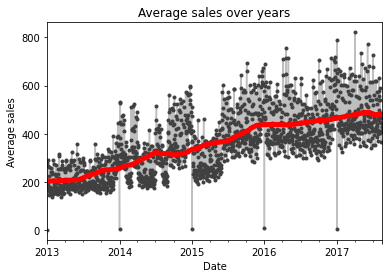

In [ ]:
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
ax=avg_sales.plot(**plot_params)
ax=moving_avg.plot(color='red',linewidth=5)
plt.xlabel('Date')
plt.ylabel('Average sales')
plt.title('Average sales over years')
plt.show()

### Trend forecast

In [ ]:
plt.style.use('seaborn-whitegrid')
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

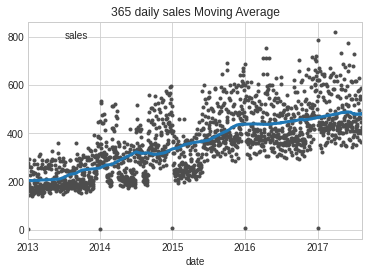

In [ ]:
# 이동 평균 구해보기 
moving_average=daily_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()
ax1=daily_sales.plot(style='.',color='0.3')
moving_average.plot(
    ax=ax1,linewidth=3,title='365 daily sales Moving Average',legend=False,
);

In [ ]:
# train[train['date']<'2013-12-31']['store_nbr'].value_counts()

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess
# 날짜별로
dp = DeterministicProcess(
    index=daily_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

In [ ]:
X = dp.in_sample()
X.head()
#in_sample 은 날짜별로 인덱스를 만들어준다.

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


In [ ]:
y=daily_sales['sales'] # The target
y.fillna(0,inplace=True)
model=LinearRegression(fit_intercept=False)
model.fit(X,y)

LinearRegression(fit_intercept=False)

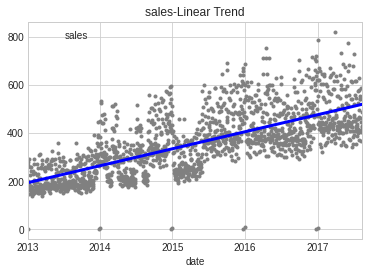

In [ ]:
y_pred=pd.Series(model.predict(X),index=X.index)
ax=daily_sales.plot(style='.',color='0.5',title='sales-Linear Trend')
linear_=y_pred.plot(ax=ax,color='blue',linewidth=3,label='linear Trend')

In [ ]:
X=dp.out_of_sample(steps=138)
y_forecast=pd.Series(model.predict(X),index=X.index)
y_forecast.tail()

2017-12-27    545.836983
2017-12-28    546.030240
2017-12-29    546.223498
2017-12-30    546.416755
2017-12-31    546.610012
Freq: D, dtype: float64

선형 회귀와 out_of sample를 통해 예측해보기

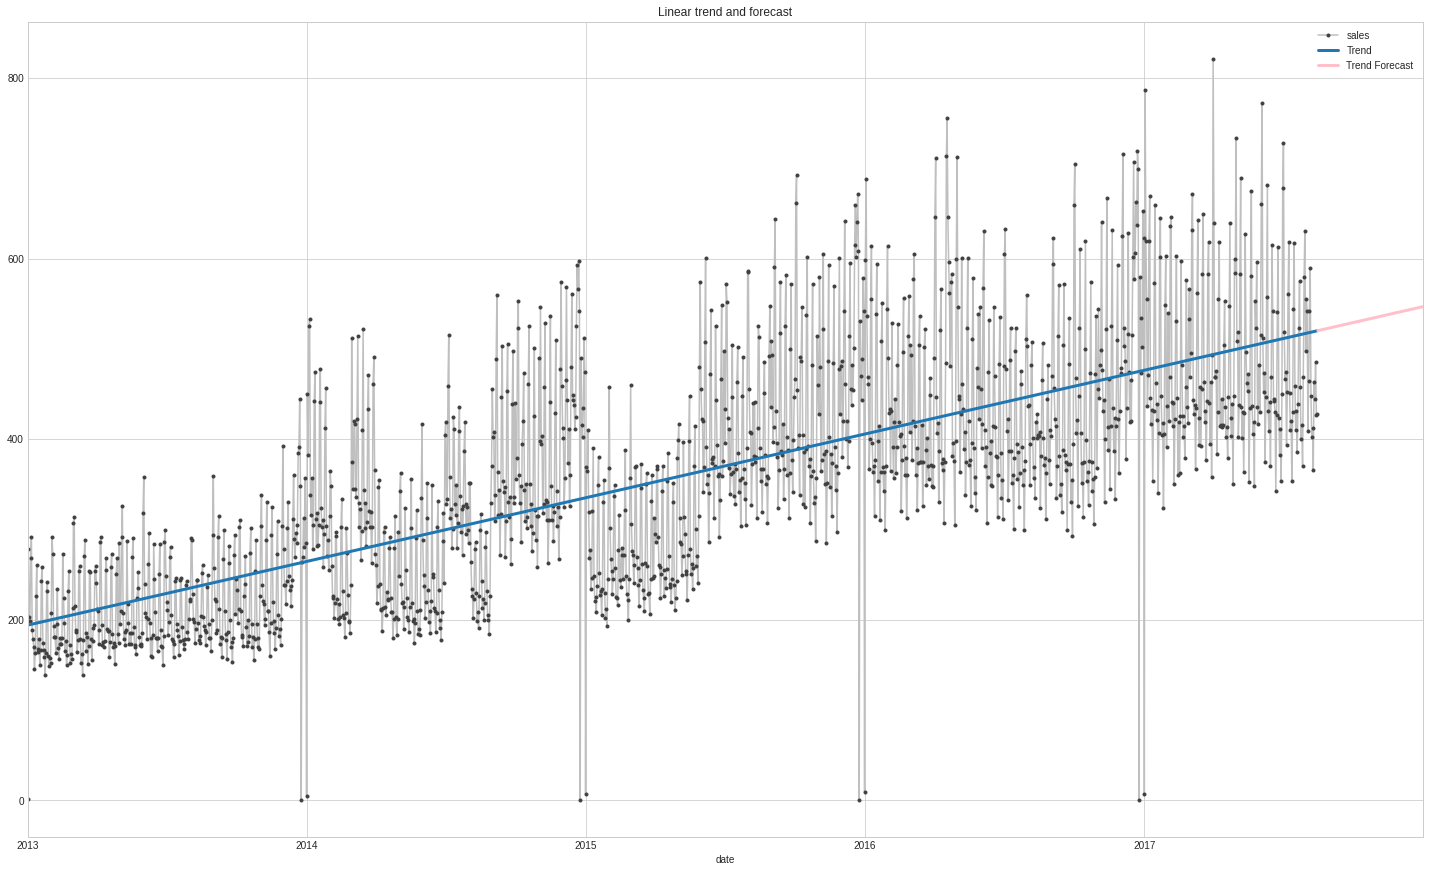

In [ ]:
fig,axes=plt.subplots(1,1,figsize=(25,15))
ax2=daily_sales.plot(title='Linear trend and forecast',ax=axes,**plot_params)
ax3=y_pred.plot(ax=ax2,linewidth=3,label='Trend')
ax3=y_forecast.plot(ax=ax3,linewidth=3,label='Trend Forecast',color='pink')
_=ax3.legend()

### EDA


어떤 것들이 상점의 매출에 영향을 주는지 파악해보자

월 별로 분석해보자

[]

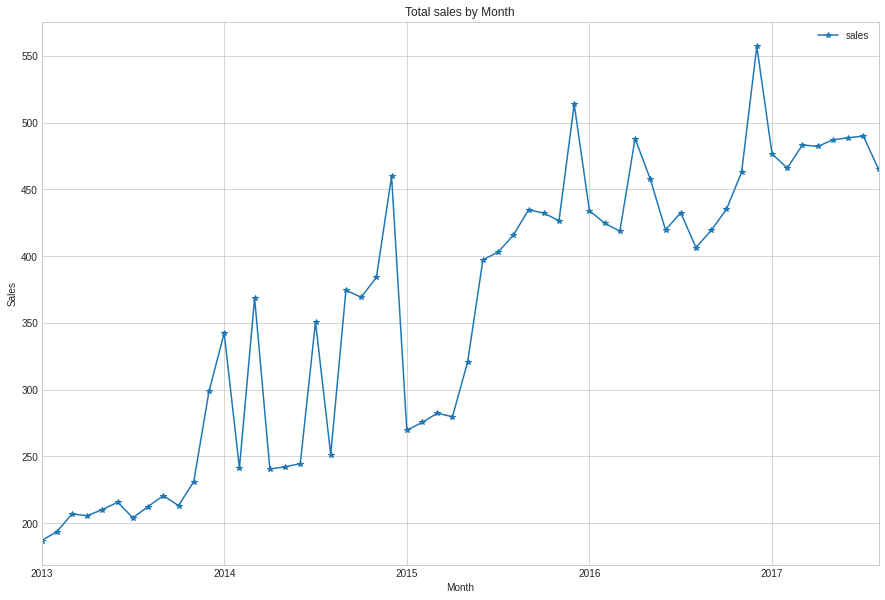

In [ ]:
monthly_sales.plot(kind='line',figsize=(15,10),marker='*')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Total sales by Month')
plt.plot()

연말로 갈수록 우상향

연도가 늘어날수록 우상향

연초마다 떡락하는 건 쉬는 날이라서?

**그럼 혹시 promotion과 sales간의 관계?**

할인한 게 많을수록 판매금액 높더라?

Text(0.5, 1.0, 'Relationship between Promotion and Sales')

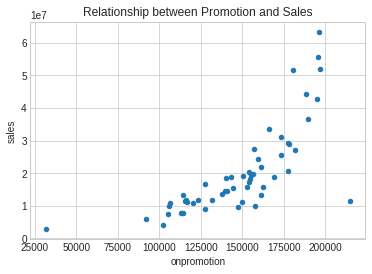

In [ ]:
promotion_sales=train_.groupby('store_nbr')[['onpromotion','sales']].sum()
promotion_sales.plot.scatter('onpromotion','sales')
plt.title('Relationship between Promotion and Sales')

**store별 판매량 비교**

가게 번호별로 판매량을 확인할 수 있음

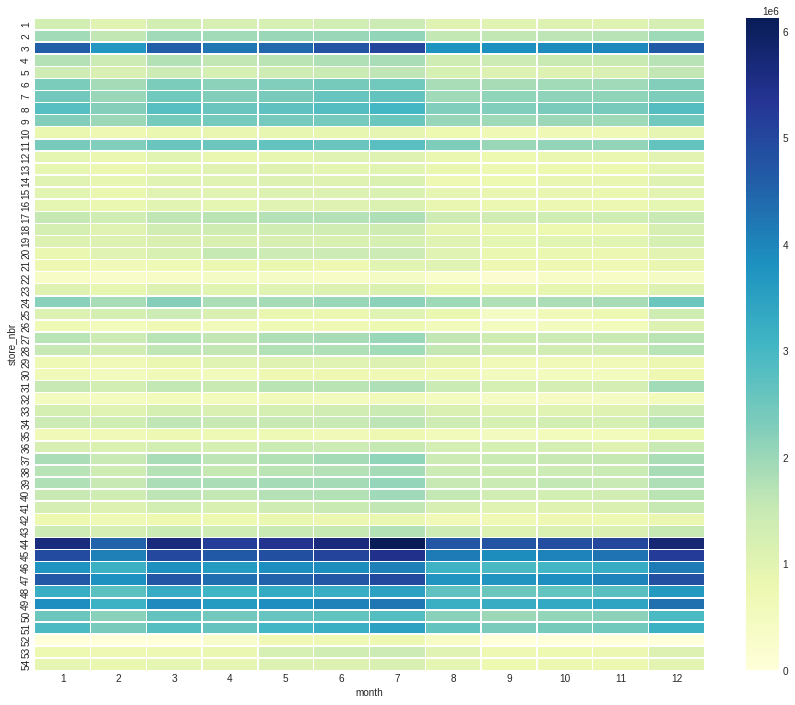

In [ ]:
table=pd.pivot_table(train_,values='sales',index=['store_nbr'],columns=['month'],aggfunc=np.sum)
fig,ax=plt.subplots(figsize=(15,12))
sns.heatmap(table,annot=False,linewidths=.5,ax=ax,cmap='YlGnBu')
plt.show()

**제품별 판매량 비교**

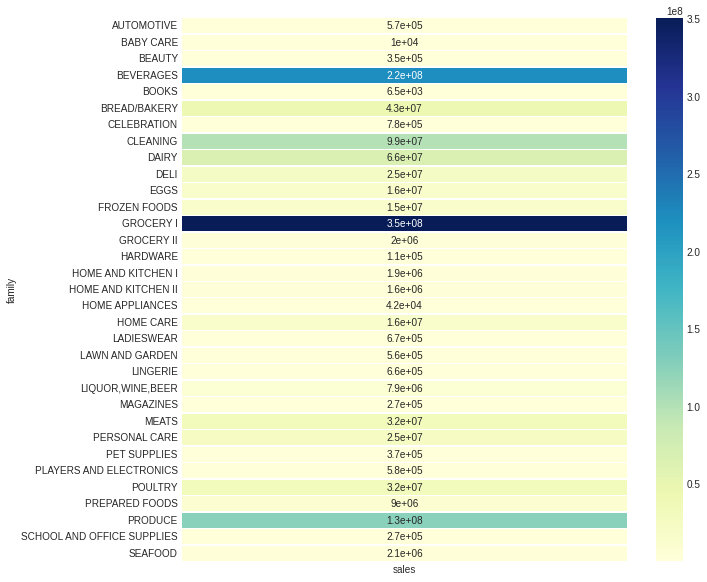

In [ ]:
sales_table=pd.pivot_table(train_,values='sales',index=['family'],aggfunc=np.sum)
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(sales_table,annot=True,linewidths=.5,ax=ax,cmap='YlGnBu')
plt.show()

**어느 요일**에 잘 팔리냐

주말에 확실히 장사가 잘되네

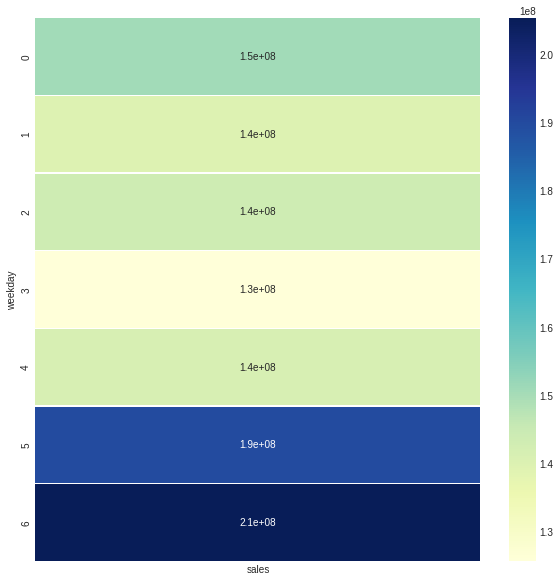

In [ ]:
day_table=pd.pivot_table(train_,values='sales',index=['weekday'],aggfunc=np.sum)
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(day_table,annot=True,linewidths=.5,ax=ax,cmap="YlGnBu")
plt.show()

**family : 판매 제품 타입**

어떤 게 제일 잘 팔릴까?

In [ ]:
sales_family=train_cp.groupby('family')['sales'].mean().sort_values(ascending=False).to_frame()
sales_family

,sales
family,
GROCERY I,3790.432861
BEVERAGES,2394.912598
PRODUCE,1355.373657
CLEANING,1074.171509
DAIRY,711.175964
BREAD/BAKERY,464.150604
POULTRY,351.078827
MEATS,341.965912
PERSONAL CARE,271.192383


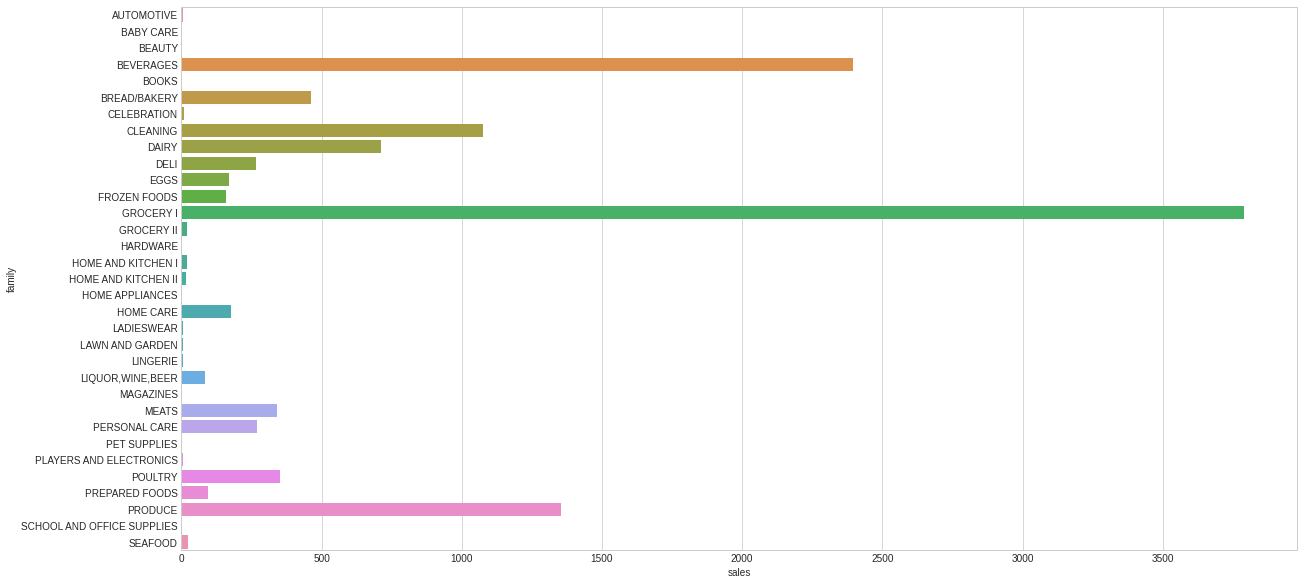

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(data=sales_family,y=sales_family.index,x=sales_family.sales)
plt.show()

식료품이 제일 많이 팔리는 것을 볼 수 있음

하드웨어, 책 등은 덜 팔림

In [ ]:
print('The best family products sell are: ',sales_family.index[:5])
print('\nThe worst family products sell are: ',sales_family.index[-5:])

The best family products sell are:  CategoricalIndex(['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY'], categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

The worst family products sell are:  CategoricalIndex(['MAGAZINES', 'HARDWARE', 'HOME APPLIANCES', 'BABY CARE',
                  'BOOKS'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')


## Machine learning model

xgboost lightgbm 모델 사용할 것임

#### baseline model

In [52]:
train_['family'].nunique()

33

linear regression for each product family

y는 이미 설정했고 x_train, x_test 설정할 필요

In [53]:
x_train=train_[col_features].query('date < "2017-06-01"')
x_test=test_[test_col_features].query('date >= "2017-06-01"')

In [54]:
xgb_params = {
    'tree_method': 'gpu_hist', 
    'gpu_id': 0,
    'predictor': 'gpu_predictor', 
    'verbosity': 2,
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'random_state': 2021,
    'learning_rate': 0.009948916127719946,
    'subsample': 0.9963593946651406,
    'colsample_bytree': 0.8056779523100791,
    'reg_alpha': 10.0,
    'reg_lambda': 0.1801543144548864,
    'min_child_weight': 47,
}

In [ ]:
x_train[x_train['is_train']==True].index

PeriodIndex(['2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
             '2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
             '2017-01-01', '2017-01-01',
             ...
             '2017-05-31', '2017-05-31', '2017-05-31', '2017-05-31',
             '2017-05-31', '2017-05-31', '2017-05-31', '2017-05-31',
             '2017-05-31', '2017-05-31'],
            dtype='period[D]', name='date', length=269082)

In [55]:
def basic_xgboost(X_train, y, xgb_params, X_test):
    start = time.time()    
    # extract train and valid dataset
    trn_idx = X_train[X_train['is_train']==True].index
    val_idx = X_train[X_train['is_valid']==True].index

    X_tr = X_train.loc[trn_idx, :].drop(['is_train', 'is_valid'], axis=1)
    X_val = X_train.loc[val_idx, :].drop(['is_train', 'is_valid'], axis=1)
    y_tr = y[trn_idx]
    y_val = y[val_idx]
    
    xgb_train = xgb.DMatrix(X_tr, label=y_tr)
    xgb_valid = xgb.DMatrix(X_val, label=y_val)
    evallist = [(xgb_train, 'train'), (xgb_valid, 'eval')]
    evals_result = dict()
    
    model = xgb.train(params=xgb_params, dtrain=xgb_train, evals=evallist, evals_result=evals_result,
                      verbose_eval=5000, num_boost_round=100000, early_stopping_rounds=100)
    
    xgb_oof = np.zeros(y_val.shape[0])
    xgb_oof = model.predict(xgb_valid, iteration_range=(0, model.best_iteration))
    
    xgb_test = xgb.DMatrix(X_test)
    xgb_pred = pd.Series(model.predict(xgb_test, iteration_range=(0, model.best_iteration)),
                         name='xgb_pred')
    
    elapsed = time.time() - start
    error_value = mean_squared_error(y_val, xgb_oof, squared=False)
    print(f"xgb rmse: {error_value:.6f}, elapsed time: {elapsed:.2f}sec\n")

    return xgb_oof, model, evals_result, xgb_pred, y_val, X_val

In [56]:
%%time
oof, model, evals_result, pred, y_val, X_val = basic_xgboost(x_train, target, xgb_params, x_test)

KeyboardInterrupt: ignored

In [ ]:
# xgb_ntree_lims=[]
# xgb_scores=[]
# from xgboost import XGBRegressor
# # 제품 타입별 
# for family in families:
#     df_train_=train_[train_.family==family].query('date < "2017-06-01"')
#     df_val_=train_[train_.family==family].query('date >= "2017-06-01"')
#     X_train_,y_train_=df_train_[col_features],df_train_[target]
#     X_val_,y_val_=df_val_[col_features],df_val_[target]
#     model=XGBRegressor(n_estimators=1000,learning_rate= 0.08,tree_method='gpu_hist')
#     model.fit(X_train_,y_train_,eval_set=[(X_train_,y_train_),(X_val_,y_val_)],early_stopping_rounds=100,verbose=0)
#     xgb_ntree_lims.append(model.best_ntree_limit)
#     xgb_scores.append(model.best_score)
#     print(f'{family} iterations : {model.best_ntree_limit} \t RMSLE for {family} : {model.best_score:.4f}')
#     results=model.evals_result()
# print(f'\nMean of RMSLE for each family scores: {np.mean(xgb_scores)}')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset
from sklearn.compose import make_column_transformer
OHEC=OneHotEncoder(
    drop='if_binary',
    handle_unknown='ignore'
)

In [ ]:
## machine learning model

### (번외) xgboost 연습

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer

In [ ]:
df=load_breast_cancer()
features=df.data
label=df.target
cancer_df=pd.DataFrame(data=features,columns=df.feature_names)
cancer_df['target']=label
cancer_df.target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(features,label,test_size=0.2,random_state=32)
#DMatrix 생성
dtrain=xgb.DMatrix(data=x_train,label=y_train)
dtest=xgb.DMatrix(data=x_test,label=y_test)

In [ ]:
params = {'max_depth':3,
         'eta':0.1,
         'objective':'binary:logistic',
         'eval_metric':'logloss',
         'early_stoppings':100}
num_rounds=400

python wrapper : 예측 결과를 추정할 수 있는 확률 값 반환

scikit-learn의 predict method :  예측 결과 클래스의 값을 반환

In [ ]:
w_list=[(dtrain,'train'),(dtest,'test')]
xgb_ml = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,\
                  early_stopping_rounds=100, evals=w_list)

In [ ]:
pred_probs=xgb_ml.predict(dtest)
pred=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개', pred[:10])

예측값 10개 [1, 1, 1, 0, 1, 1, 1, 1, 1, 0]


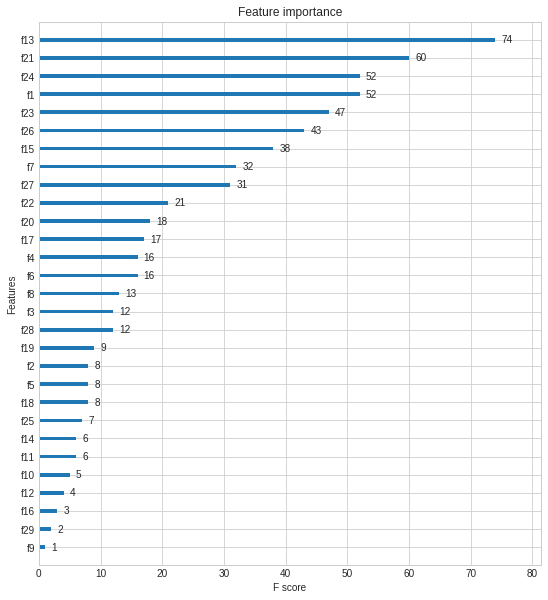

In [ ]:
fig,ax=plt.subplots(figsize=(9,10))
plot_importance(xgb_ml,ax=ax)